* Import files



In [9]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_tabular import LimeTabularExplainer


*Import Data file

In [11]:
coloumn_names=["age","sex","cp","trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak","slope","ca","thal","num"]
#cleavland dataset
df_cleavland=pd.read_csv("processed.cleveland.data",names=coloumn_names)

* Pre Processing

In [12]:
# Converting data type string to numeric
df_cleavland['ca'] = pd.to_numeric(df_cleavland['ca'], errors='coerce')
df_cleavland['thal'] = pd.to_numeric(df_cleavland['thal'], errors='coerce')

# repalcing ? with NA
df_cleavland.replace('?',np.nan, inplace=True)

df_cleavland = df_cleavland.dropna()
#Converting taget coloumn values to 0 and 1
df_cleavland['num'] = df_cleavland['num'].apply(lambda x: 0 if x == 0 else 1)
#df_cleavland.shape

* Preparing Features and target DataLoader

In [13]:
X=df_cleavland.drop('num',axis=1).values
y=df_cleavland['num'].values

X_temp, X_test, y_temp,y_test = train_test_split(X,y,test_size=0.2,shuffle=True, random_state=123,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,shuffle=True, random_state=123,stratify=y_temp)
X_train.shape

(189, 13)

* Correlation matrix of features

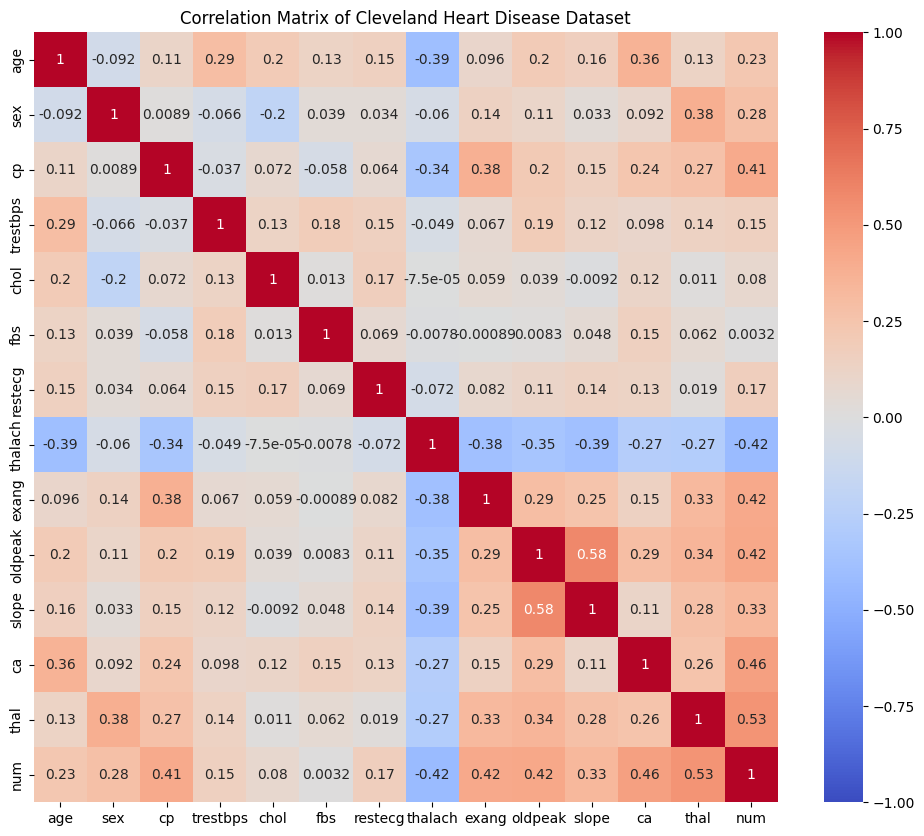

In [14]:
corr_matrix=df_cleavland.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Cleveland Heart Disease Dataset')
plt.show()

* XGBoost

In [17]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import xgboost as xgb

# Define the parameter grid
param = {
    'max_depth':[3, 5, 7,8,10],
    'eta': [0.01, 0.05, 0.1,0.3]  # learning rate
    }


# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                           param_grid=param,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train, y_train)

best_model_xgb = grid_search.best_estimator_
y_pred = best_model_xgb.predict(X_val)
accuracy = accuracy_score(y_val,y_pred)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("Validation Accuracy: %0.2f" % accuracy)




Best parameters: {'eta': 0.05, 'max_depth': 7}
Validation Accuracy: 0.81


* Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 10))
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_val_scaled = scaler.transform(X_val)          # Transform validation data
X_test_scaled = scaler.transform(X_test)


# Step 4: Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Wider range of regularization values
    'penalty': ['l1', 'l2'],                   # Include both L1 and L2 penalties
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Different solvers
}

# Step 5: Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),  # Base logistic regression model
    param_distributions=param_dist,              # Hyperparameter distributions
    n_iter=6,                                   # Number of parameter settings to try
    cv=5,                                        # 5-fold cross-validation
    scoring='accuracy',                          # Use accuracy as the evaluation metric
    random_state=42,                             # Ensure reproducibility
    n_jobs=-1,                                   # Use all available processors
    verbose=0                                    # Print progress during search
)

# Step 6: Fit RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Step 7: Get the best parameters and model
best_params = random_search.best_params_
best_model_log = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the tuned model on the validation set
y_val_pred = best_model_log.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")



Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 10}
Validation Accuracy: 0.81


/Users/prabhakarmanikyam/opt/anaconda3/envs/pyml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/prabhakarmanikyam/opt/anaconda3/envs/pyml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/prabhakarmanikyam/opt/anaconda3/envs/pyml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/prabhakarmanikyam/opt/anaconda3/envs/pyml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/prabhakarmanikyam/opt/anaconda3/envs/pyml/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was

* Random Forest

In [22]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9)
}

randmforest = RandomForestClassifier(random_state=42)
random_searchf = RandomizedSearchCV(
    estimator=randmforest,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_searchf.fit(X_train,y_train)
best_model_rnf=random_searchf.best_estimator_
print(f'Best param:{random_searchf.best_params_}')

y_pred_rnn=best_model_rnf.predict(X_val)
accuracy_score_rnf=accuracy_score(y_val,y_pred_rnn)
print(f'Accuracy score:{accuracy_score_rnf}')



Best param:{'max_depth': 28, 'max_features': np.float64(0.45539336635801275), 'min_samples_leaf': 8, 'min_samples_split': 12, 'n_estimators': 598}
Accuracy score:0.8333333333333334


* ANN

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_train_ann = scaler.fit_transform(X_train)
X_val_ann = scaler.transform(X_val)
X_test_ann = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_ann, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension
X_val_tensor = torch.tensor(X_val_ann, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_ann, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [24]:
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)


# Instantiate the model
input_size = X_train_ann.shape[1]  # Number of features
model = HeartDiseaseNN(input_size)
# Loss function: Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Optimizer: Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [27]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation performance
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_preds = (val_outputs >= 0.5).float()  # Threshold for binary classification
            val_accuracy = accuracy_score(y_val, val_preds.numpy())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

#print(model.score(X_train_tensor,y_train_tensor))

Epoch [10/100], Loss: 0.4430, Validation Loss: 0.4885, Validation Accuracy: 0.8125
Epoch [20/100], Loss: 0.3581, Validation Loss: 0.4216, Validation Accuracy: 0.8542
Epoch [30/100], Loss: 0.2724, Validation Loss: 0.3643, Validation Accuracy: 0.8542
Epoch [40/100], Loss: 0.2302, Validation Loss: 0.3545, Validation Accuracy: 0.8542
Epoch [50/100], Loss: 0.2072, Validation Loss: 0.3633, Validation Accuracy: 0.8542
Epoch [60/100], Loss: 0.1885, Validation Loss: 0.3703, Validation Accuracy: 0.8542
Epoch [70/100], Loss: 0.1692, Validation Loss: 0.3831, Validation Accuracy: 0.8750
Epoch [80/100], Loss: 0.1566, Validation Loss: 0.3918, Validation Accuracy: 0.8750
Epoch [90/100], Loss: 0.1468, Validation Loss: 0.4212, Validation Accuracy: 0.8542
Epoch [100/100], Loss: 0.1378, Validation Loss: 0.4524, Validation Accuracy: 0.8333


### Random Forest and ANN give the highest accuracy on validation set

In [28]:
#Random Forest Test

y_test_rnf=best_model_rnf.predict(X_test)
accuracy_score_test=accuracy_score(y_test,y_test_rnf)
print(f'Test accuracy: {accuracy_score_rnf:.2%}')

Test accuracy: 83.33%


In [29]:
#Logistic Regression
y_test_log=best_model_log.predict(X_test_scaled)
accuracy_score_test_log=accuracy_score(y_test,y_test_log)
print(f'{accuracy_score_test_log}')

0.85


In [ ]:
#XGBoost
y_test_xgb=best_model_xgb.predict(X_test)
accuracy_score_test_xgb=accuracy_score(y_test,y_test_xgb)
print(f'Test accuracy:{accuracy_score_test_xgb:.2%}')
#print(y_test[0])
#print(y_test_xgb[0])

Test accuracy:88.33%


In [30]:
#ANN
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs >= 0.5).float()  # Threshold for binary classification
    test_accuracy_ann = accuracy_score(y_test, test_preds.numpy())
    print(f"\nTest Accuracy: {test_accuracy_ann * 100:.2f}%")


Test Accuracy: 85.00%


### Evaluating metrics for XGBoost since it has highest accuracy:

True predictions: 53
False predictions: 7


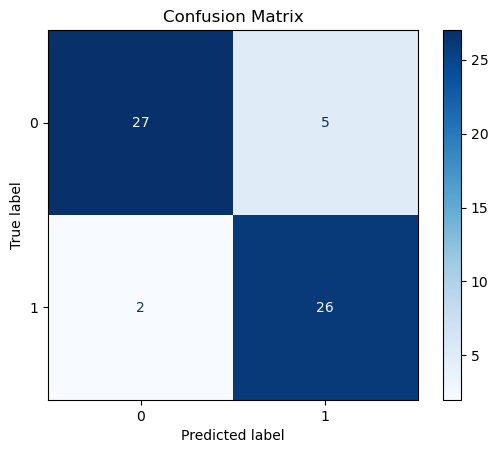

In [ ]:
#Confusion metrics and scores for XGBoost

cm = confusion_matrix(y_test, y_test_xgb)

true_predictions = np.sum(np.diag(cm))
false_predictions = np.sum(cm) - true_predictions
class_names = best_model_xgb.classes_.tolist()
print("True predictions:", true_predictions)
print("False predictions:", false_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Scores
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score
mcc = matthews_corrcoef(y_test, y_test_xgb)
f1 = f1_score(y_test, y_test_xgb, average='weighted')
precision = precision_score(y_test, y_test_xgb, average='weighted')

# Display results
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision Score: {precision:.4f}")

Matthews Correlation Coefficient (MCC): 0.7710
F1 Score: 0.8834
Precision Score: 0.8879


### LIME for Model Explanation



In [ ]:
scaler = MinMaxScaler(feature_range=(0, 5))  # Scale features between 0 and 10
X_train_scaled_lm = scaler.fit_transform(X_train)
X_test_scaled_lm = scaler.transform(X_test)
feature_names=["age","sex","cp","trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak","slope","ca","thal"]
# Create a LIME Tabular Explainer
explainer = LimeTabularExplainer(
    X_train_scaled_lm,
    training_labels=y_train,
    feature_names=feature_names,
    class_names=["No Heart Disease", "Heart Disease"],
    mode="classification",
    discretize_continuous=True
)


def model_predict(x):
    # Check if x is already 2D
    if x.ndim == 1:
        x = x.reshape(1, -1)
    # Ensure x has the correct number of features
    if x.shape[1] != 13:
        raise ValueError(f"Expected 13 features, but got {x.shape[1]}")
    return best_model_xgb.predict_proba(x)

# Now try LIME with this wrapper
exp = explainer.explain_instance(
    X_test_scaled_lm[0],
    model_predict,
    num_features=13  # Start with a small number of features
)
exp.show_in_notebook(show_all=True)